# Otimização do sistema de manutenção de caminhões de uma frota


## Descrição do problema

Nesta análise nós exploramos uma base de dados que contém informações sobre os veículos de uma frota de caminhões. As informações gerais sobre os veículos encontram-se em colunas com nomenclatura codificada e também temos uma coluna que indica se o veículo precisou realizar manutenção no sistema de ar.

O principal objetivo desta análise é aplicar técnicas de Machine Learning para prever os veículos que precisarão de manutenção. Essa predição poderia então ser utilizada para reduzir os custos da empresa. 

Uma manutenção preventiva custa $\$10$ e previne que um caminhão apresente problemas nos sistema de ar. Se por outro lado um caminhão não realizar a manutenção preventiva e apresentar problema no sistema de ar, ele então precisará de uma manutenção corretiva que custa $\$500$.   

Temos dados de 2016 à 2019, que chamaremos de dados pré 2020, e também dados de 2020. Além disso, sabemos quanto foi o custo da mutenção do sistema de ar da frota em 2020. A ideia central desse projeto é que se obtivermos uma boa predição dos veículos que precisarão manutenção e a mutenção preventiva (que é muito mais barata) for realizada nesses veículos preditos, então a empresa poderá reduzir os seus custos com manutenção. 

Nós iremos explorar e ajustar modelos de classificação nos dados pré 2020. O modelo com a melhor performance será aplicado nos dados de 2020 e obteremos então o valor que poderia ter sido economizado em 2020 caso uma estratégia de manutenção baseada na predição de modelos estatísticos tivesse sido empregada.   

Também iremos investigar quais são as principais váriaveis na predição da manutenção de um veículo.

## Carregamento dos dados

In [1]:
# importa as principais bibliotecas que serão utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# carrega os dados pré 2020
df_pre = pd.read_csv('data_pre_2020.csv')

# carrega os dados de 2020
df = pd.read_csv('data_2020.csv')

## Explorando os dados

In [3]:
df_pre.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


Esse conjunto de dados apresenta dimensionalidade bastante alta. Nós iremos remover as colunas com um número de dados faltantes acima de um limiar definido para reduzir a dimensionalidade do problema.

In [4]:
# verifica o número de dados faltantes em cada coluna
num_falt = (df_pre == 'na').sum()
print(num_falt)

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64


Há diversas colunas com muitos dados faltantes.

In [5]:
def col_faltantes(limiar):
    """
        Recebe um valor limiar e retorna uma lista com o nomde das colunas 
        que apresentam um número de dados faltantes maior que o limiar
    """
    
    # colunas com mais de "limiar" dados faltantes
    col = []

    for i in range(len(num_falt)):
        if num_falt[i] > limiar:
            col.append((num_falt.index)[i])
            
    return col        

In [6]:
# realiza várias das etapas do pré-processamento
def pre_process(data_frame, limiar):
    new_data_frame = data_frame.copy()

    # colunas para serem removidas
    col_rem = col_faltantes(limiar)

    # remove as colunas
    new_data_frame.drop(col_rem, axis = 1, inplace = True)
    
    # mapeia as strings 'neg' e 'pos' da coluna 'class' nos valores 0 e 1, respectivamente
    new_data_frame['class'] = new_data_frame['class'].map({'neg' : 0, 'pos' : 1})

    # subsititui as strings 'na' por np.NaN
    new_data_frame = new_data_frame.replace('na', np.NaN)
    
    # transforma todos os dados em float
    new_data_frame = new_data_frame.astype(float)
    
    # substitui os valores faltantes pelas médias das colunas
    new_data_frame = new_data_frame.fillna(new_data_frame.mean())
    
    return new_data_frame

## Importação de bibliotecas adicionais 

In [7]:
# biblioteca para normalização das variáveis
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
# importa as bibliotecas de alguns modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Definição do limiar de dados faltantes nas colunas

Para diminuir o tempo de execução, nesta etapa iremos utilizar árvores de decisão e validação por holdout. 

In [10]:
# modelo de árvore de decisão
tree = DecisionTreeClassifier()

Iremos testar diferentes limiares para determinarmos um limiar adequado para a classificação.

In [15]:
# cria array com os limiares que serão testados
n_faltantes = np.arange(500, 2100, 100)

# lista com o valor da sensibilidade de cada limiar
sens = []

for n in n_faltantes:
    df_pre_clean = pre_process(df_pre, n)
    scaler.fit(df_pre_clean)
    df_pre_rescaled = pd.DataFrame(scaler.transform(df_pre_clean))

    # define as variáveis preditoras e a variável resposta
    X = df_pre_rescaled.drop(0, axis = 1)
    y = df_pre_rescaled[0]
    
    sensibilidade = 0
    
    for i in range(10): # roda 10 vezes para se calcular a média das sensibilidades 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # ajuste do modelo
        tree.fit(X_train, y_train)
        # predição 
        pred = tree.predict(X_test)
        # calcula a sensibilidade/recall do modelo 
        sensibilidade += metrics.recall_score(y_test, pred)  

    sens.append(sensibilidade/10)

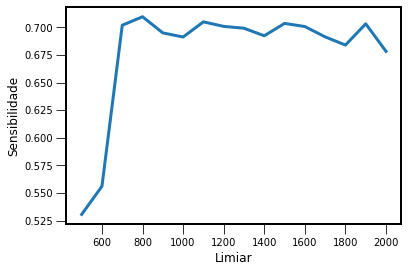

In [16]:
# plot da sensibilidade do modelo como função do limiar
plt.plot(n_faltantes, np.array(sens))
plt.xlabel('Limiar')
plt.ylabel('Sensibilidade')
plt.show()

Esses resultados indicam que as colunas com até 700 dados faltantes já fornecem uma boa performance na classificação. Nós iremos utilizar esse valor como limiar para eliminar algumas variáveis.

In [11]:
# verifica quantas colunas apresentam mais de (700) dos dados faltantes 
menos_de_700 = sum(num_falt < 700) 
mais_de_700 = sum(num_falt > 700)
      
print('Existem:\n')        
print('\u2022 {} colunas com menos de 700 dados faltantes \n'.format(menos_de_700))  
print('\u2022 {} colunas com mais de 700 dados faltantes \n'.format(mais_de_700))        

Existem:

• 99 colunas com menos de 700 dados faltantes 

• 72 colunas com mais de 700 dados faltantes 



## Teste de modelos de classificação

Nesta etapa iremos realizar a validação pelo método K-fold

In [12]:
# define o método de validação do modelo, utilizamos Kfold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)

In [13]:
def teste_modelos(var_pred, var_resp):
  """
      Aplica diferentes modelos de classificação nos dados de entrada e retorna um DataFrame 
      com as métricas de avaliação dos modelos.
  """  

  lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
  nome_das_medidas = ['acurácia', 'sensibilidade', 'precisão', 'eficiência', 'f1-score']

  lista_de_modelos = [    DecisionTreeClassifier(max_depth = 7),
                          BaggingClassifier(),
                          RandomForestClassifier(n_estimators=50, max_depth = 5),
                          XGBClassifier()]

  nome_dos_modelos = [    'Árvore (prof = 7)',
                          'Bagging',
                          'Random Forest (arvs = 50, prof = 5)',
                          'XGBoost'] 
  resultados0 = {}

  for i in range(len(lista_de_modelos)):

      print('Rodando modelo: ' + nome_dos_modelos[i])

      accs_vc = cross_validate(lista_de_modelos[i], var_pred, var_resp, cv = validacao, scoring = lista_de_medidas)

      acc = accs_vc['test_accuracy'].mean()
      sen = accs_vc['test_recall'].mean()
      vpp = accs_vc['test_precision'].mean()
      bac = accs_vc['test_balanced_accuracy'].mean()
      f1s = accs_vc['test_f1'].mean()

      resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, bac, f1s]
      
      
  return pd.DataFrame(resultados0, index = nome_das_medidas).T


In [14]:
# pré-processamento dos dados com um limiar de 700
df_pre_clean = pre_process(df_pre, 700)

# normalização dos dados
scaler.fit(df_pre_clean)
df_pre_rescaled = pd.DataFrame(scaler.transform(df_pre_clean))

In [15]:
# define as variáveis preditoras e a variável resposta
X = df_pre_rescaled.drop(0, axis = 1)
y = df_pre_rescaled[0]

In [22]:
resultados = teste_modelos(X, y)
resultados.sort_values(by = 'sensibilidade', ascending = False)

Rodando modelo: Árvore (prof = 7)
Rodando modelo: Bagging
Rodando modelo: Random Forest (arvs = 50, prof = 5)
Rodando modelo: XGBoost


,acurácia,sensibilidade,precisão,eficiência,f1-score
XGBoost,0.994633,0.760,0.903304,0.879305,0.825032
Bagging,0.993067,0.670,0.887592,0.834271,0.762447
Árvore (prof = 7),0.991033,0.602,0.813295,0.799814,0.689794
"Random Forest (arvs = 50, prof = 5)",0.990733,0.508,0.890267,0.753458,0.645714


O modelo XGBoost é superior em todas as métricas. Iremos portanto utilizá-lo nas análises seguintes.


## "Corrigindo" o desbalanceamento das classes

Esses dados apresentam grande desbalanceamento nas classes.

In [16]:
# contagem de classes
pre_classe_cont_neg, pre_classe_cont_pos = df_pre['class'].value_counts()

print('\u2022 {} dos dados pertencem à classe "neg" \n'.format(pre_classe_cont_neg))
print('\u2022 {} dos dados pertencem à classe "pos" \n'.format(pre_classe_cont_pos))

• 59000 dos dados pertencem à classe "neg" 

• 1000 dos dados pertencem à classe "pos" 



Nós iremos adicionar um maior peso na classificação para a classe minoritária e, portanto, forçar o modelo a realizar um melhor ajuste na predição da classe "pos".

No XGBoost isso pode ser realizado através do hyperparâmetro "scale_pos_weight".

Em geral, a escolha mais intuitiva e direta para esse parâmetro é a razao entre o número de dados da classe majoritária e a minoritária, 59 no nosso caso. Entretanto, nós iremos realizar uma tunagem mais ampla para verificar como se comporta o modelo conforme esses pesos são adicionados. 

In [24]:
# tunagem do hyperparâmetro 'scale_pos_weight'

from sklearn.model_selection import GridSearchCV

parametros = {'scale_pos_weight' : [10, 30, 59, 100, 500, 1000]}

xgboost = XGBClassifier()
grid_search = GridSearchCV(xgboost, param_grid = parametros,
                                   scoring = 'recall', 
                                   cv = validacao, 
                                   verbose = 1,
                                   n_jobs = -1)

grid_search.fit(X, y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     in...
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     m

In [70]:
print('O peso {} fornece a melhor sensibilidade, com valor de {:.2f}.'.format(grid_search.best_params_['scale_pos_weight'], grid_search.best_score_))

O peso 1000 fornece a melhor sensibilidade, com valor de 0.83.


A sensibilidade, que é a métrica mais relevante para esse problema, é muito superior quando esse peso maior é adicionado na classe minoritária.

A "sensibilidade" nos dá a fração dos veículos que apresentaram defeito no sistema de ar que o modelo é capaz de prever.

## Pré-processamento dos dados de 2020

In [17]:
df_clean = pre_process(df, 700)
df_rescaled = pd.DataFrame(scaler.transform(df_clean))

## Aplicando os modelos nos dados de 2020

Aplicação do modelo XGBoost sem nenhuma "correção" do desbalanceamento entre as classes.

In [18]:
# define o modelo
xgboost = XGBClassifier()

In [19]:
# ajusta o modelo em toda a base pré 2020
xgboost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [20]:
# define as variáveis preditivas e de resposta dos dados de 2020
X_2020 = df_rescaled.iloc[:, 1:]
y_2020 = df_rescaled.iloc[:, 0]

In [21]:
# predição 
pred_2020 = xgboost.predict(X_2020)

In [22]:
# calcula a sensibilidade/recall do modelo quando aplicado nos dados de 2020
sens = metrics.recall_score(y_2020, pred_2020)
print('O modelo é capaz de prever {:.2%} dos veículos que precisaram de manutenção em 2020.'.format(sens))

O modelo é capaz de prever 78.67% dos veículos que precisaram de manutenção em 2020.


Aplicação do modelo XGBoost adicionando um peso maior na classe minoritária.

In [23]:
# define o modelo
xgboost_weighted = XGBClassifier(scale_pos_weight = 1000)

In [24]:
# ajusta o modelo na base balanceada pré 2020
xgboost_weighted.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [25]:
# predição 
pred_2020_weighted = xgboost_weighted.predict(X_2020)

In [26]:
# calcula a sensibilidade/recall do modelo quando aplicado nos dados de 2020 e com peso na classe minoritária
sens = metrics.recall_score(y_2020, pred_2020_weighted)                        
print('O modelo, quando treinado "corrigindo-se" o desbalanceamento entre as classes, é capaz de prever {:.2%} dos veículos que precisaram de manutenção em 2020.'.format(sens))

O modelo, quando treinado "corrigindo-se" o desbalanceamento entre as classes, é capaz de prever 84.80% dos veículos que precisaram de manutenção em 2020.


## Considerações sobre os resultados do modelo e os valores gastos

Utilizamos os resultados do modelo treinado com um peso maior na classe minoritária, que forneceu uma sensibilidade consideravelmente superior.

In [30]:
# número de previsões positivas
pred_pos = sum(pred_2020_weighted == 1)

# número de positivos nos dados
num_pos = sum(y_2020 == 1)

print('O modelo prediz a manutenção de {} veículos e os dados apresentam {} veículos que precisaram de manutenção.'.format(pred_pos, num_pos))

O modelo prediz a manutenção de 396 veículos e os dados apresentam 375 veículos que precisaram de manutenção.


In [32]:
# número de veículos preditos corretamente
corr_pos = sens * num_pos

# número de veículos que precisaram de manutenção mas não foram preditos
nao_pred = num_pos - corr_pos

print('O modelo prediz corretamente {} veículos que precisaram de manutenção e {} veículos \n precisaram de manutenção mas não foram preditos.'.format(corr_pos, nao_pred))

O modelo prediz corretamente 318.0 veículos que precisaram de manutenção e 57.0 veículos 
 precisaram de manutenção mas não foram preditos.


In [35]:
# valor da manutenção preventiva
v1 = 10
#valor da manutenção corretiva
v2 = 500

# valor gasto
total = pred_pos * v1 + nao_pred * v2

print('Se as manutenções fossem realizadas conforme as predições do modelo a empresa teria gastado ${}.'.format(total))

Se as manutenções fossem realizadas conforme as predições do modelo a empresa teria gastado $32460.0.


In [37]:
# valor que foi gasto em 2020
gasto_2020 = 187500

# valor economizado
economia = gasto_2020 - total

print('A economia teria sido de ${}.'.format(economia))

A economia teria sido de $155040.0.


## Variáveis de importância

In [39]:
# calcula a importância relativa das variáveis
feature_importances = xgboost_weighted.feature_importances_

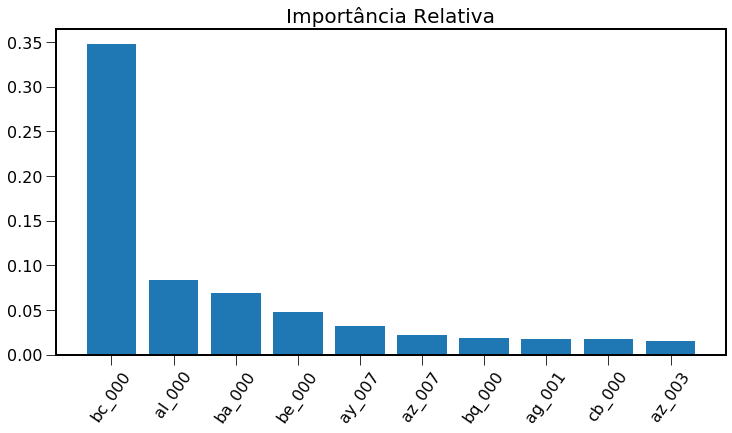

In [40]:
# ordena as variáveis em ordem ascendente de importância
sorted_feat_imp = np.sort(feature_importances)

# guarda a nova ordem dos índices após o reordenamento
arg = feature_importances.argsort()

# retorna o nome das variáveis
feature_names = df_pre.drop('class', axis = 1).columns

# reordena os nomes de acordo com o ordenamento de importância
sorted_feat_names = feature_names[arg]

# número de variáveis para serem exibidas no boxplot com as importâncias relativas
num_features = 10

# barplot com as importâncias relativas
fig = plt.figure(figsize = (12, 6))
plt.bar(sorted_feat_names[::-1][:num_features], sorted_feat_imp[::-1][:num_features])
plt.xticks(fontsize = 16, rotation = 55)
plt.yticks(fontsize = 16)
plt.title('Importância Relativa', fontsize = 20)
plt.show()

A variável bc_000 é a variável de maior importância na predição das manutenções e com grande superioridade sobre as demais. 